# Identificação

- Discente: Helder Mateus dos Reis Matos
- Matrícula: 202520080003
- Disciplina: Fundamentos de Inteligência Computacional e Ciência de Dados
- Docente: Claudomiro de Souza de Sales Junior
- Tarefa: Atividade 03 - Sample distribution and sampling distribution, TLC and p-value

- Link para o Colab (modo leitura): 

# 0. Configurações

In [ ]:
!wget -O pso.py https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade02/pso.py

--2025-05-02 02:08:31--  https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade02/pso.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4961 (4,8K) [tex

In [1]:
import itertools
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scipy.stats import norm
import scipy.stats as stats

from pso import Particle, Swarm, ackley, particle_swarm_optimization

# 1. Sample distribution and sampling distribution

*A partir do que foi feito na Atividade 2 “Considerando o primeiro trabalho, defina um experimento em que dados são coletados de uma variável de interesse do seu trabalho”, crie uma população artificial dessa variável com uma distribuição Gaussiana e demonstre sample distribution and sampling distribution. Faça avaliações de probabilidade de possíveis eventos.*

Nesta atividade, a variável de interesse é o melhor valor de fitness _z_ obtido pelo algoritmo Particle Swarm Optimization (PSO) em execuções sobre a função Ackley bidimensional. Essa variável representa a qualidade da solução encontrada em cada experimento de otimização, sendo diretamente afetada pelo desempenho do algoritmo. Para fins didáticos, será gerada uma população artificial com distribuição Gaussiana baseada nessa variável, de modo a possibilitar a demonstração dos conceitos de sample distribution e sampling distribution, bem como a avaliação de probabilidades associadas a eventos estatísticos relevantes.

In [4]:
n = 1000

runs = []
etime = []

for _ in range(n):
    start_time = time.time()

    run = particle_swarm_optimization(
        cost_function=ackley,
        DIMENSIONS=2, GLOBAL_BEST=0,
        B_LO=-10, B_HI=10,
        POPULATION=20, V_MAX=0.1,
        PERSONAL_C=2.0, SOCIAL_C=2.0,
        CONVERGENCE=0.001, MAX_ITER=100
    )

    end_time = time.time()

    runs.append(run)
    etime.append(end_time - start_time)

data_pso = {
    "x": [r[0][0] for r in runs],
    "y": [r[0][1] for r in runs],
    "z": [r[1] for r in runs],
    "etime": etime,
    "convergence": ["Yes" if r[2] < 100 else "No" for r in runs],
}

df_pso = pd.DataFrame(data_pso)
df_pso

,x,y,z,etime,convergence
0,-0.000019,-0.000020,0.000078,0.023905,Yes
1,0.000029,0.000292,0.000831,0.022304,Yes
2,-0.000386,0.001321,0.003943,0.024399,No
3,0.000055,0.000237,0.000690,0.022265,Yes
4,0.001153,-0.002270,0.007373,0.024301,No
...,...,...,...,...,...
995,-0.000321,-0.000089,0.000946,0.015116,Yes
996,0.000300,0.000183,0.000999,0.009347,Yes
997,0.000197,0.000224,0.000846,0.012253,Yes
998,-0.000254,0.000167,0.000862,0.014097,Yes


## 1.1. Sample distribution

In [5]:
sample = df_pso["etime"].sample(10)
sample_mean = sample.mean()
sample_std = sample.std()

print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")

Sample mean: 0.0201
Sample std: 0.0049


In [6]:
sample = df_pso["etime"].sample(10)
sample_mean = sample.mean()
sample_std = sample.std()

print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")

Sample mean: 0.0176
Sample std: 0.0046


In [7]:
sample = df_pso["etime"].sample(10)
sample_mean = sample.mean()
sample_std = sample.std()

print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")

Sample mean: 0.0173
Sample std: 0.0075


## 1.2. Sampling distribution

In [8]:
sampling = [df_pso["etime"].sample(10).mean() for _ in range(100)]

/tmp/ipykernel_69588/3685332490.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


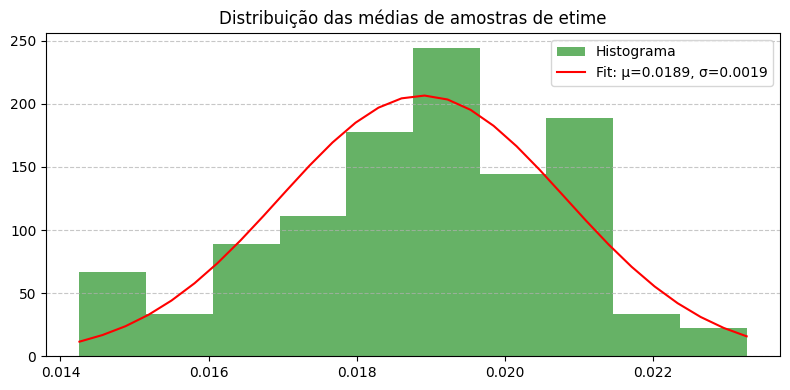

In [31]:
def histogram_experiment(s):
    fig, axs = plt.subplots(figsize=(8, 4))

    axs.hist(s, bins=10, density=True, alpha=0.6, color='g', label="Histograma")

    mu, sigma = norm.fit(s)
    x = np.linspace(min(s), max(s), 30)
    pdf = norm.pdf(x, mu, sigma)

    axs.plot(x, pdf, 'r-', label=f"Fit: μ={mu:.4f}, σ={sigma:.4f}")

    axs.grid(axis='y', linestyle='--', alpha=0.7)

    axs.set_title(f"Distribuição das médias de amostras de etime")

    axs.legend(loc='upper right', fontsize=10)

    fig.tight_layout()

    fig.show()

histogram_experiment(sampling)

# 2. TLC

_Aplique o TLC a função de distribuição gama e avalie quatro diferentes tamanhos de amostra, começando em 10._

# 3. p-value

_Faça um programa que mostra o passo a passo para calcular o p-value do evento abaixo. Coloque figuras para cada passo._

<p align="center">
  <img src="https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade03/imagens/c.png" alt="Imagem da Atividade 03" width="600">
</p>

# 4. p-value

_Crie  duas  Gaussianas  como  mostrado  abaixo  (é  só  variar  a média). Sortei 100 sequências de três valores na azul e para cada sequência calcule o p-value a partir da vermelha. Veja a seta vermelha que indica a partir de qual amostra é calculado p-value. Calcule a taxa de falso negativos (p-value acima de 5%)._

<p align="center">
  <img src="https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade03/imagens/d.png" alt="Imagem da Atividade 03" width="600">
</p>

Interpretação estatística:

- Hipótese nula ($H_{0}$): os dados vêm da distribuição vermelha.
- Hipótese alternativa ($H_{1}$): os dados vêm de outra distribuição --- no caso, a azul.
- Como os dados realmente vêm da azul, a hipótese nula é falsa.
Quando o p-valor $> 0.05$, não rejeitamos a hipótese nula.
- Portanto, estamos comentendo um falso negativo (erro tipo II): a hipótese nula é falsa, mas não a rejeitamos.